# Predicting Seagrass Habitats with Machine Learning

<img src="./img/vrf_teaser.png" />

The goals is to establish a relationship between ocean measurements at a given location and sea-grass occurrence using a supervised  machine learning method called random forest.  

### About the Random Forest 

- Supervised learning algorithm
- Random forest builds multiple decision trees and merges them together to get a better prediction


## Seagrass Importance

<img src="./imgs/seagrass.jpg"/>

Like rainforests, seagrasses are disappearing from the earth's surface. Seagrasses are underwater forests that provide food and shelter for a wide array of animals, including crabs, turtles, and birds (some of which are critical to local economies). 

## Data Preparation

<img src="./imgs/combined.png"/>

### Load the Data

- Use Spatially Enabled DataFrames to prepare the data for the model


In [1]:
import pandas as pd
from arcgis.features import FeatureLayer
from arcgis.features import GeoAccessor, GeoSeriesAccessor

In [2]:
url = ("https://services3.arcgis.com/oZfKvdlWHN1MwS48/arc"
       "gis/rest/services/MachineLearningSeagrass/FeatureServer/1")
fl = FeatureLayer(url)

sdf = (
    pd
    .DataFrame
    .spatial
    .from_layer(fl)
)
sdf.head()

,CID,Join_Count,NameEMU,OBJECTID,Present,SHAPE,TARGET_FID,appO2,depth,dissO2,nitrate,percO2,phosphate,salinity,silicate,temp
0,10,1,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",1,0,"{""x"": -9157126.894340137, ""y"": 3070014.1739909...",1,-0.097869,0,5.038187,0.503541,102.16810,0.070516,35.69495,3.878356,24.75329
1,10,1,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",2,0,"{""x"": -9036857.89479882, ""y"": 3463385.75717355...",2,0.051061,0,4.710738,0.836354,99.08915,0.124987,35.98500,1.521608,24.13740
2,10,1,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",3,1,"{""x"": -8937164.61534358, ""y"": 2953422.22280594...",3,1.941822,0,3.839985,15.172270,69.50264,1.032444,35.58104,10.742860,18.00565
3,10,1,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",4,1,"{""x"": -9117387.817445286, ""y"": 2823643.6009130...",4,1.972570,0,3.654587,14.109170,67.56322,0.936634,35.46936,9.925514,14.55408
4,10,1,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",5,0,"{""x"": -9107781.908575488, ""y"": 2819315.5718083...",5,2.000643,0,3.721700,14.746720,67.79740,0.980522,35.41380,10.737210,13.48950


### Obtain Columns of Interest

In [3]:
sdf.columns = [col.upper() for col in sdf.columns]
sdf.columns

Index(['CID', 'JOIN_COUNT', 'NAMEEMU', 'OBJECTID', 'PRESENT', 'SHAPE',
       'TARGET_FID', 'APPO2', 'DEPTH', 'DISSO2', 'NITRATE', 'PERCO2',
       'PHOSPHATE', 'SALINITY', 'SILICATE', 'TEMP'],
      dtype='object')

In [4]:
sdf_copy = sdf[['DISSO2', 'NITRATE', 'PERCO2','PHOSPHATE', 
                'SALINITY', 'SILICATE', 'TEMP', 
                'NAMEEMU', 'PRESENT', 'SHAPE']].copy()
sdf_copy.head(2)

,DISSO2,NITRATE,PERCO2,PHOSPHATE,SALINITY,SILICATE,TEMP,NAMEEMU,PRESENT,SHAPE
0,5.038187,0.503541,102.16810,0.070516,35.69495,3.878356,24.75329,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0,"{""x"": -9157126.894340137, ""y"": 3070014.1739909..."
1,4.710738,0.836354,99.08915,0.124987,35.98500,1.521608,24.13740,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0,"{""x"": -9036857.89479882, ""y"": 3463385.75717355..."


### Convert Categorical Data to Numeric

In [5]:
cat_variables = pd.get_dummies(sdf_copy['NAMEEMU'])
sdf_copy.drop("NAMEEMU", axis=1, inplace=True)

In [6]:
sdf_copy = sdf_copy.join(cat_variables)

In [7]:
new_names = ['C1', 'C2', 'C3']
for  ind, name in enumerate(new_names):
    sdf_copy.rename(
        columns={sdf_copy.columns[len(sdf_copy.columns[:-3])+ind]:name},
    inplace=True)

### Evaluate Correlation Between Predictors

- ignore the categorical values

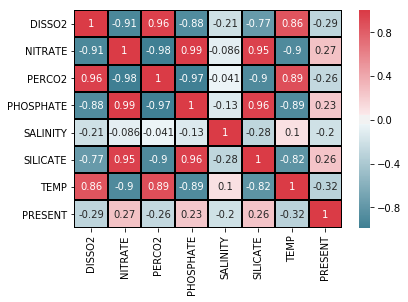

In [53]:
import seaborn as sns
corr = sdf_copy.drop(sdf_copy.columns[-4:], 
                     axis = 1).astype('float64').corr()

#Plot Correlation Matrix Between Prediction Variables
ax = sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            annot = True, linecolor = 'k', linewidths = 1)

### Create Training and Testing Data

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
test, train = train_test_split(sdf_copy, test_size=0.1)
indicator, _ = pd.factorize(train["PRESENT"])
print('Training Data Size = ' + str(train.shape[0]))
print('Test Data Size = ' + str(test.shape[0]))

Training Data Size = 10000
Test Data Size = 90000


## Perform Random Forest Classification

### Create the Classifier

In [10]:
predictVars = ['SALINITY', 'TEMP', 'PHOSPHATE', 
               'NITRATE', 'SILICATE', 'DISSO2', 'C1',
              'C2', 'C3']
#Name of Classification Variable
classVar = ['PRESENT']

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
rfco = RandomForestClassifier(n_estimators=500, oob_score=True)
rfco.fit(train[predictVars], indicator)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

### Plot Variable of Importance

In [13]:
import numpy as np
import matplotlib.pyplot as plt

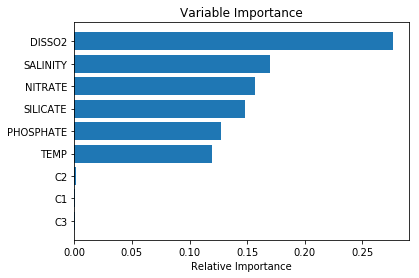

In [14]:
pos = np.arange(len(predictVars)) + .5
imp_sorted = np.argsort(rfco.feature_importances_)
sortedVars = [predictVars[i] for i in imp_sorted]
plt.barh(pos, rfco.feature_importances_[imp_sorted], align='center')
plt.yticks(pos, sortedVars)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Predict Seagrass Occurrence on the Test

In [15]:
seagrass_pred = rfco.predict(test[predictVars])
seagrass_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

### Calculate Prediction Accuracy

In [16]:
test_seagrass = test["PRESENT"].values
test_seagrass = test_seagrass.flatten()
test_seagrass

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

### Calculate Estimation Error

In [17]:
error = np.sum(test_seagrass - seagrass_pred)/len(seagrass_pred) * 100
print('Accuracy = ' + str(100 - np.abs(error)) + ' % ')
print('Locations with Seagrass = ' + str(len(np.where(test_seagrass==1)[0])) )
print('Predicted Locations with Seagrass = ' + str(len(np.where(seagrass_pred==1)[0])))

Accuracy = 99.74111111111111 % 
Locations with Seagrass = 27748
Predicted Locations with Seagrass = 27515
